## Data Cleaning

We will perform an analysis of the features present 

** Basic imports **

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as nd
import pandas as pd
import math
import matplotlib.pyplot as plt

import os
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display


from collections import Counter


** load data **

Here we are using a small toy dataset to explore the data

In [2]:
inputFile='../../data/smallData/rawData/AcceptedLoans.csv'
outputFile = '../../data/tmp/Simon/AcceptedLoans.csv'
data=pd.read_csv(inputFile)

C:\Users\simon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(103496, 145)

** check the type of the data series**

In [4]:
data.dtypes

id                                            float64
member_id                                     float64
loan_amnt                                       int64
funded_amnt                                     int64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

Check the type of data

Text(0.5,1,'types encountered in the dataset')

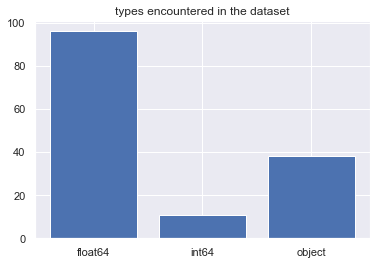

In [5]:
types=data.dtypes

typesSeen=[]
for t in types:
    if not t in typesSeen:
        typesSeen+=[t]

counts=[]
for t in typesSeen:
    counts+= [(types==t).sum()]

plt.bar(range(len(counts)), counts)
plt.xticks(range(len(counts)), typesSeen)
plt.title('types encountered in the dataset')

In [6]:
counts

[96, 11, 38]

## CLEAN THE OBJECT FEATURES

In [7]:
objFeatures=types[types=='object'].keys()


In [8]:
print('object features : {} entries'.format(len(objFeatures)))
print(list(objFeatures))


object features : 38 entries
['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date']


* id

Id is indeed a float feature, I just put it here for demo

1- Outline

We will proove that `id` is an empty attribute and remove it from the dataset

2- Analysis

In [9]:
vals_id = data['id']
number_of_null_entries = vals_id.isnull().count()
number_of_entries = vals_id.shape[0]

In [10]:
print('{} empty values over {} entries'.format(number_of_null_entries, number_of_entries))
print('ratio {}%'.format(number_of_null_entries/number_of_entries *100))

103496 empty values over 103496 entries
ratio 100.0%


3- Conclusion 

`id` is an empty attribute, we can remove it

In [11]:
data=data.drop('id', axis=1)

- term

1- Outline

It can take either 36 or 60 months. It seems to fit perfectly to a categorical variable, 0 or 1.
0 for 36 months and 1 for 60 months

2- Analysis

In [12]:
data['term'].value_counts()

 36 months    73600
 60 months    29896
Name: term, dtype: int64

In [13]:
from pandas.api.types import CategoricalDtype

t = CategoricalDtype(categories=[" 36 months", " 60 months"], ordered=True)
te=  data.term.astype(t)
data['term']=te.cat.codes

In [14]:
data['term'].head()

0    0
1    1
2    0
3    0
4    1
Name: term, dtype: int8

3- Conclusion

The data.term is now a binary feature taking 0 or 1

* int_rate

1- Outline

it is a percentage, we will convert it into a float, between 0 and 100

2- Analysis

In [15]:
def convertIntRate(s):
    """
    input : string of int_rate
    output : float between 0 and 100 corresponding to the interest rate
    """
    without_percent = s[:-1]
    number =float(without_percent)
    return(number)

In [16]:
data['int_rate']= data['int_rate'].apply(convertIntRate)

3- Conclusion

the column has been modified

In [17]:
data['int_rate'].dtype

dtype('float64')

* grade

1- Outline

This is a categorical variable with 7 levels, we will use dummy encoding

2- Analysis

In [18]:
Counter(data['grade'])

Counter({'A': 25812,
         'B': 31279,
         'C': 25087,
         'D': 14426,
         'E': 5041,
         'F': 1460,
         'G': 391})

In [19]:
dummies = pd.get_dummies(data['grade'], prefix='grade')

In [20]:
data=pd.concat([data, dummies], axis=1)


In [21]:
data=data.drop('grade', axis=1)

3- Conclusion

We removed the attribute grade and added grade_A, ...

In [22]:
data[['grade_A', 'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']].head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0


* sub_grade

1- Outline

Sub-categories of grade. categorical variable of 7*5 entries.
We could create 35 dummies but instead, we will give numerical values to the corresponding grade.

Exemple:

sub_grade = A1 --> grade_A=1

sub_grade = D4 --> grade_D=4

sub_grade = A3 --> grade_A=2

2- Analysis

In [23]:
def embed_subGrade(df):
    col, val = df['sub_grade'][0],df['sub_grade'][1]
    df['grade_'+col]=val
    return(df)

In [24]:
data = data.apply(embed_subGrade, axis=1)

In [25]:
data=data.drop('sub_grade', axis=1)

3- Conclusion 

The sub_grades have been embedded in the grades

In [26]:
data[['grade_A', 'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']].head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0,2,0,0,0,0,0
1,0,0,4,0,0,0,0
2,0,0,5,0,0,0,0
3,0,0,1,0,0,0,0
4,0,5,0,0,0,0,0


* emp_title

Contains the name of the borrower'job , it does not seem to be a relevant feature for our analysis. We will remove it from the dataset

In [27]:
data=data.drop('emp_title', axis=1)

* emp_length

1- Outline

Categorical variable, we embed it using replacement. See below.

There are some missing values, we will not touch them first, but the fact that there are nan values, forces us to store this variable as float and not as int

2- Analysis

In [28]:
dict(Counter(data['emp_length']))

{nan: 6880,
 '9 years': 3043,
 '4 years': 7517,
 '2 years': 10470,
 '1 year': 7472,
 '< 1 year': 8837,
 '3 years': 9438,
 '5 years': 7284,
 '7 years': 4104,
 '10+ years': 29971,
 '8 years': 3445,
 '6 years': 5035}

In [29]:
length_to_int = dict()
length_to_int['< 1 year']=0
length_to_int['1 year']=1
length_to_int['2 years']=2
length_to_int['3 years']=3
length_to_int['4 years']=4
length_to_int['5 years']=5
length_to_int['6 years']=6
length_to_int['7 years']=7
length_to_int['8 years']=8
length_to_int['9 years']=9
length_to_int['10+ years']=10

In [30]:
length_to_int

{'1 year': 1,
 '10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '4 years': 4,
 '5 years': 5,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9,
 '< 1 year': 0}

In [31]:
#store empty indexes
emp_length_missing = data['emp_length'].isnull()

In [32]:
def embed_emp_length(s):
    """
    convert the string emp_length into an integer
    does not change the NaN input
    """
    try:
        return(length_to_int[s])
    except:
        pass
        

In [33]:
data['emp_length']= data['emp_length'].apply(embed_emp_length)

3- Conclusion

We replaced the string inputs and did not modify the nan iputs

In [34]:
data['emp_length'].head()

0    10.0
1     0.0
2    10.0
3    10.0
4     1.0
Name: emp_length, dtype: float64

* home_ownership

categorical variable, we use dummy encoding on 4 levels : it is useless to add an extra variable for a predictor HOME_None that appears only 3 times...

In [35]:
Counter(data['home_ownership'])

Counter({'ANY': 1,
         'MORTGAGE': 48296,
         'NONE': 3,
         'OTHER': 98,
         'OWN': 11421,
         'RENT': 43677})

In [36]:
dum = pd.get_dummies(data['home_ownership'], prefix='HOME')
data=pd.concat([data, dum], axis=1)

In [37]:
data = data.drop('home_ownership', axis=1)

In [38]:
# remove the HOME_NONE attribute
data = data[data['HOME_NONE']==0]

In [39]:
data=data.drop('HOME_NONE', axis=1) #only 3 points
data=data.drop('HOME_RENT', axis=1) #to avoid colinearity

In [40]:
data[['HOME_MORTGAGE', 'HOME_OTHER', 'HOME_OWN']].head()

,HOME_MORTGAGE,HOME_OTHER,HOME_OWN
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


* verification_status

1- Outline

Categorical variable, we will create dummy embeddings


2- Analysis

In [41]:
Counter(data['verification_status'])

Counter({'Not Verified': 40990, 'Source Verified': 34714, 'Verified': 27789})

In [42]:
dum = pd.get_dummies(data['verification_status'], prefix='Income')

In [43]:
dum.keys()

Index(['Income_Not Verified', 'Income_Source Verified', 'Income_Verified'], dtype='object')

In [44]:
data=pd.concat([data, dum], axis=1)

In [45]:
data=data.drop('Income_Not Verified', axis=1) #to avoid colinearity

3- Conclusion 

The new columns have been added, with correct name

In [46]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,...,grade_D,grade_E,grade_F,grade_G,HOME_ANY,HOME_MORTGAGE,HOME_OTHER,HOME_OWN,Income_Source Verified,Income_Verified
0,NaN,5000,5000,4975.0,0,10.65,162.87,10.0,24000.0,Verified,...,0,0,0,0,0,0,0,0,0,1
1,NaN,2500,2500,2500.0,1,15.27,59.83,0.0,30000.0,Source Verified,...,0,0,0,0,0,0,0,0,1,0
2,NaN,2400,2400,2400.0,0,15.96,84.33,10.0,12252.0,Not Verified,...,0,0,0,0,0,0,0,0,0,0
3,NaN,10000,10000,10000.0,0,13.49,339.31,10.0,49200.0,Source Verified,...,0,0,0,0,0,0,0,0,1,0
4,NaN,3000,3000,3000.0,1,12.69,67.79,1.0,80000.0,Source Verified,...,0,0,0,0,0,0,0,0,1,0


* issue_d

In [164]:
def extract_day_and_month(s):
    [x1,x2]=s.split('-')
    try:
        day=int(x1)
        month=x2
    except:
        month=x1
        day=int(x2)
    return (day, month)

In [165]:
tupled = data['issue_d'].apply(extract_day_and_month)

In [183]:
extracted = list(zip(*(tupled.values )))

In [184]:
days, months = extracted[0], extracted[1]

In [188]:
data['issue_d_day']=days

In [190]:
data['issue_d_month']=months

In [191]:
data = data.drop('issue_d', axis=1)

* loan_status

1- Outline

2-level categorical variable, we will create a categorical variable, 0 for fully paid and 1 for Charged Off

In [48]:
Counter(data['loan_status'])

Counter({'Charged Off': 5885,
         'Current': 57940,
         'Fully Paid': 38071,
         'In Grace Period': 662,
         'Late (16-30 days)': 239,
         'Late (31-120 days)': 696})

In [49]:
categories_loan_status = list(Counter(data['loan_status']).keys())

In [50]:
categories_loan_status

['In Grace Period',
 'Late (16-30 days)',
 'Late (31-120 days)',
 'Current',
 'Charged Off',
 'Fully Paid']

In [51]:

t = CategoricalDtype(categories=categories_loan_status, ordered=True)
te=  data['loan_status'].astype(t)
data['loan_status']=te.cat.codes

3- Conclusion

We embedded this feature

In [52]:
data['loan_status'].head()

0    5
1    4
2    5
3    5
4    5
Name: loan_status, dtype: int8

* pymnt_plan

1- Outline

Constant variable, we will remove it

2- Analysis

In [53]:
Counter(data['pymnt_plan'])

Counter({'n': 103492, 'y': 1})

In [54]:
data = data.drop('pymnt_plan', axis=1)

* desc

1- Outline

natural language text, for  now we remove it but we will may use NLP techniques

2- Analysis

In [55]:
data['desc'].head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

In [56]:
data = data.drop('desc', axis=1)

3- Conclusion

The colummn has been removed

* purpose

1- Outline 

Categorical variable, we will use dummy encoding 

2- Analysis

In [57]:
Counter(data['purpose'])

Counter({'car': 2398,
         'credit_card': 19459,
         'debt_consolidation': 51120,
         'educational': 325,
         'home_improvement': 7703,
         'house': 1363,
         'major_purchase': 4106,
         'medical': 1730,
         'moving': 1027,
         'other': 9710,
         'renewable_energy': 137,
         'small_business': 2614,
         'vacation': 850,
         'wedding': 951})

In [58]:
dum = pd.get_dummies(data['purpose'] , prefix= 'purpose')

In [59]:
dum = dum.drop('purpose_debt_consolidation', axis=1) #to avoid colinearity

In [60]:
data=pd.concat([data, dum], axis=1)

3- Conclusion 

The columns have been added

In [61]:
categories_purpose = list(Counter(dum).keys())

In [62]:
data[categories_purpose].head()

,purpose_house,purpose_vacation,purpose_educational,purpose_renewable_energy,purpose_car,purpose_small_business,purpose_credit_card,purpose_wedding,purpose_other,purpose_medical,purpose_home_improvement,purpose_moving,purpose_major_purchase
0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0


* title

1- Outline

Similar to desc, we will remove it

2- Analysis

In [63]:
data['title'].head()

0                Computer
1                    bike
2    real estate business
3                personel
4                Personal
Name: title, dtype: object

In [64]:
data = data.drop('title', axis=1)

3- Outline

The column has been removed

* zip_code

1- Outline
Categorical variable, we will use a replace method as we have a lot of entries

2- Analysis

In [65]:
categories_zip_code =  list(Counter(data['zip_code']).keys())

t = CategoricalDtype(categories=categories_zip_code, ordered=True)
te=  data['zip_code'].astype(t)
data['zip_code']=te.cat.codes

-3 Conclusion

We replaced the string values with integers

In [66]:
data['zip_code'].max()

880

* addr_state

1- Outline

Same as zip_code, we will use replace()

2- Analysis

In [67]:
categories_addr_state=list(Counter(data['addr_state']).keys())

In [68]:
t = CategoricalDtype(categories=categories_addr_state, ordered=True)
te=  data['addr_state'].astype(t)
data['addr_state']=te.cat.codes

-3 Conclusion

We replaced the string values with integers

In [69]:
data['addr_state'].max()

50

* earliest_cr_line

In [70]:
def f(s):
    try:
        int(s[-2:])
        return(True)
    except:
        return(False)

In [71]:
data['earliest_cr_line'].apply(f).sum()

91881

In [192]:
data['earliest_cr_line']

0         Jan-85
1         Apr-99
2          1-Nov
3         Feb-96
4         Jan-96
5          4-Nov
6          5-Jul
7          7-Jan
8          4-Apr
9          4-Sep
10        Jan-98
11        Oct-89
12         4-Apr
13         3-Jul
14        May-91
15         7-Sep
16        Oct-98
17        Aug-93
18         3-Oct
19         1-Jan
20        Nov-97
21        Feb-83
22        Jul-85
23         3-Apr
24         1-Jun
25         2-Feb
26         3-Oct
27         3-Oct
28        Aug-84
29         6-Nov
           ...  
103466    Oct-04
103467    Nov-01
103468    Feb-01
103469    Aug-03
103470    May-07
103471    Feb-92
103472    Feb-01
103473    Dec-05
103474    Sep-01
103475    Oct-00
103476    Dec-01
103477    Dec-02
103478    Jan-80
103479    Nov-89
103480    Oct-99
103481    Mar-01
103482    Apr-07
103483    Jun-07
103484    Mar-97
103485    Aug-04
103486    Nov-05
103487    Jan-08
103488    Nov-14
103489    Apr-02
103490    Sep-06
103491    Aug-13
103492    Feb-02
103493    Jan-

* revol_util

1- Outline

Percentage, we will convert it to float

2- Analysis

In [72]:
def convert_Revol2Float(s):
    '''
    convert the string of revol_util into a float corresponding to the percentage
    '''
    try:
        return(float(s[:-1]))
    except:
        print(s)
        return(s)

In [73]:
data['revol_util']=data['revol_util'].apply(convert_Revol2Float)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


3- Outline

We replaced this column

In [74]:
print('number of empty vallues : ', data['revol_util'].isna().sum())

number of empty vallues :  132


In [75]:
revol_util_missing = data['revol_util'].isna()

* initial_list_status

categorical variable, 2 levels 0 for f and 1 for w 

In [76]:
def convert_initial_list_status(s):
    if s=='f':
        return(0)
    elif s=='w':
        return(1)
    else:
        print(s)
        return(s)

In [77]:
Counter(data['initial_list_status'])

Counter({'f': 49440, 'w': 54053})

In [78]:
data['initial_list_status'] = data['initial_list_status'].apply(convert_initial_list_status)

In [79]:
data['initial_list_status'].head()

0    0
1    0
2    0
3    0
4    0
Name: initial_list_status, dtype: int64

* last_pymnt_d

1- Outline

Date, I don't know yet how to handle it...

In [80]:
Counter(data['last_pymnt_d'])

Counter({nan: 173,
         '14-Feb': 792,
         '15-Apr': 136,
         'Jun-18': 980,
         '13-Apr': 851,
         '13-Mar': 1026,
         'Feb-18': 111,
         '11-Oct': 453,
         '8-Sep': 12,
         '16-Jan': 186,
         '8-Nov': 10,
         '15-Dec': 177,
         '10-Feb': 112,
         '17-Apr': 1,
         '16-Feb': 174,
         '8-Dec': 14,
         '16-Oct': 164,
         '13-Nov': 671,
         '10-Aug': 151,
         '15-Sep': 202,
         '16-Jul': 146,
         '12-Apr': 734,
         '11-Sep': 450,
         '16-Apr': 177,
         '13-Feb': 869,
         '9-Feb': 33,
         '13-May': 907,
         '12-Sep': 761,
         '13-Dec': 780,
         '11-Apr': 420,
         '10-Nov': 195,
         '13-Jul': 776,
         '14-Apr': 674,
         '11-May': 386,
         '13-Jan': 784,
         '15-May': 147,
         '15-Oct': 187,
         '15-Feb': 163,
         '15-Mar': 182,
         '14-Jan': 832,
         '8-May': 14,
         '8-Aug': 13,
         '

* last_credit_pull_d

In [81]:
Counter(data['last_credit_pull_d'])

Counter({nan: 3,
         '18-Feb': 438,
         '14-Feb': 327,
         '13-Mar': 406,
         '15-Dec': 258,
         '7-Oct': 3,
         '17-Aug': 394,
         '8-Dec': 5,
         '12-Aug': 235,
         '13-Nov': 293,
         '18-Oct': 8022,
         '16-Jul': 267,
         '11-Sep': 102,
         '13-Feb': 536,
         '9-Feb': 15,
         '13-Dec': 253,
         'Dec-17': 1,
         '10-Nov': 61,
         '13-Jul': 250,
         '14-Apr': 299,
         '11-May': 140,
         '15-Oct': 242,
         '15-Feb': 200,
         '14-Jan': 312,
         '18-Apr': 479,
         '14-Sep': 343,
         '15-Jul': 268,
         'Jan-18': 266,
         '14-Jul': 345,
         '13-Sep': 248,
         '14-Jun': 284,
         '7-Dec': 1,
         '12-Sep': 258,
         '13-Aug': 230,
         '9-Apr': 15,
         '12-May': 231,
         '15-May': 221,
         '17-Jun': 303,
         '8-Jul': 1,
         '13-Oct': 258,
         '12-Jan': 158,
         '10-Mar': 38,
         '12-Jul':

* application_type

categorical variable, 0 for individual 1 for joint

In [82]:
Counter(data['application_type'])

Counter({'Individual': 93670, 'Joint App': 9823})

In [83]:
def convert_application_type(s):
    if s=='Individual':
        return(0)
    elif s=='Joint App':
        return(1)
    else:
        return(s)
    

In [84]:
data['application_type'] = data['application_type'].apply(convert_application_type)

In [85]:
data['application_type'].head()

0    0
1    0
2    0
3    0
4    0
Name: application_type, dtype: int64

* verification_status_joint

Categorical variable, We will use only 2 variables to avoid colinearity : joint_Income_Verified and joint_Income_SourceVerified


In [86]:
dum = pd.get_dummies(data['verification_status_joint'], prefix='jointIncome')

In [87]:
dum = dum.drop('jointIncome_Not Verified', axis=1)

In [88]:
dum.head()

,jointIncome_Source Verified,jointIncome_Verified
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [89]:
data=pd.concat([data, dum], axis=1)

In [90]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,jointIncome_Source Verified,jointIncome_Verified
0,NaN,5000,5000,4975.0,0,10.65,162.87,10.0,24000.0,Verified,...,0,0,0,0,0,0,0,0,0,0
1,NaN,2500,2500,2500.0,1,15.27,59.83,0.0,30000.0,Source Verified,...,0,0,0,0,0,0,0,0,0,0
2,NaN,2400,2400,2400.0,0,15.96,84.33,10.0,12252.0,Not Verified,...,0,0,0,0,0,1,0,0,0,0
3,NaN,10000,10000,10000.0,0,13.49,339.31,10.0,49200.0,Source Verified,...,0,0,0,1,0,0,0,0,0,0
4,NaN,3000,3000,3000.0,1,12.69,67.79,1.0,80000.0,Source Verified,...,0,0,0,1,0,0,0,0,0,0


* sec_app_earliest_cr_line

In [91]:
Counter(data['sec_app_earliest_cr_line'][data['sec_app_earliest_cr_line'].notnull()])

Counter({'Apr-00': 38,
         'Apr-01': 35,
         'Apr-02': 29,
         'Apr-03': 40,
         'Apr-04': 55,
         'Apr-05': 51,
         'Apr-06': 56,
         'Apr-07': 59,
         'Apr-08': 44,
         'Apr-09': 14,
         'Apr-10': 20,
         'Apr-11': 15,
         'Apr-12': 15,
         'Apr-13': 15,
         'Apr-14': 17,
         'Apr-15': 13,
         'Apr-16': 7,
         'Apr-17': 5,
         'Apr-71': 1,
         'Apr-72': 1,
         'Apr-73': 1,
         'Apr-76': 1,
         'Apr-77': 5,
         'Apr-78': 1,
         'Apr-80': 1,
         'Apr-81': 1,
         'Apr-82': 5,
         'Apr-83': 4,
         'Apr-84': 3,
         'Apr-85': 4,
         'Apr-86': 4,
         'Apr-87': 6,
         'Apr-88': 7,
         'Apr-89': 19,
         'Apr-90': 8,
         'Apr-91': 9,
         'Apr-92': 11,
         'Apr-93': 13,
         'Apr-94': 8,
         'Apr-95': 14,
         'Apr-96': 12,
         'Apr-97': 24,
         'Apr-98': 24,
         'Apr-99': 32,
        

* hardship_flag

empty variable, we will remove it

In [92]:
Counter(data['hardship_flag'])

Counter({'N': 103492, 'Y': 1})

In [93]:
data= data.drop('hardship_flag', axis=1)

* hardship_type

constant variable, we will remove it

In [94]:
print('percentage of missing data ', data['hardship_type'].isna().sum()/data.shape[0])

percentage of missing data  0.9999903375107495


In [95]:
data= data.drop('hardship_type', axis=1)

* hardship_reason

constant variable, we will remove it

In [96]:
print('percentage of missing data ', data['hardship_reason'].isna().sum()/data.shape[0])

percentage of missing data  0.9999903375107495


In [97]:
data= data.drop('hardship_reason', axis=1)

* hardship_status

Constant variable, we will remove it 

In [98]:
print('percentage of missing data ', data['hardship_status'].isna().sum()/data.shape[0])

percentage of missing data  0.9999903375107495


In [99]:
data= data.drop('hardship_status', axis=1)

* hardship_start_date

Constant variable, we will remove it 

In [100]:
print('percentage of missing data ', data['hardship_start_date'].isna().sum()/data.shape[0])

percentage of missing data  0.9999903375107495


In [101]:
data= data.drop('hardship_start_date', axis=1)

* hardship_end_date

Constant variable, we will remove it 

In [102]:
print('percentage of missing data ', data['hardship_end_date'].isna().sum()/data.shape[0])

percentage of missing data  0.9999903375107495


In [103]:
data= data.drop('hardship_end_date', axis=1)

* payment_plan_start_date

Constant variable, we will remove it 

In [104]:
print('percentage of missing data ', data['payment_plan_start_date'].isna().sum()/data.shape[0])

percentage of missing data  0.9999903375107495


In [105]:
data= data.drop('payment_plan_start_date', axis=1)

* hardship_loan_status

Constant variable, we will remove it 

In [106]:
print('percentage of missing data ', data['hardship_loan_status'].isna().sum()/data.shape[0])

percentage of missing data  0.9999903375107495


In [107]:
data= data.drop('hardship_loan_status', axis=1)

* disbursement_method

Binary categorical variable, 0 is cash, 1 will be directPay

In [108]:
Counter(data['disbursement_method'])

Counter({'Cash': 98541, 'DirectPay': 4952})

In [109]:
def convert_disbursement_method(s):
    if s == 'Cash':
        return(0)
    elif s=='DirectPay':
        return(1)
    else:
        return(s)

In [110]:
data['disbursement_method'] = data['disbursement_method'].apply(convert_disbursement_method)

In [111]:
data['disbursement_method'].head()

0    0
1    0
2    0
3    0
4    0
Name: disbursement_method, dtype: int64

* debt_settlement_flag

binary categorical variable, 0 is No 1 is Yes

In [112]:
Counter(data['debt_settlement_flag'])

Counter({'N': 103334, 'Y': 159})

In [113]:
def convert_debt_settlement_flag(s):
    if s == 'N':
        return(0)
    elif s=='Y':
        return(1)
    else:
        return(s)

In [114]:
data['debt_settlement_flag']=data['debt_settlement_flag'].apply(convert_debt_settlement_flag)

In [115]:
data['debt_settlement_flag'].head()

0    0
1    0
2    0
3    0
4    0
Name: debt_settlement_flag, dtype: int64

* debt_settlement_flag_date

a lot of empty values, but still...this is a date we will look at it after

In [116]:
data['debt_settlement_flag_date'][data['debt_settlement_flag_date'].notnull()].head()

105    16-Feb
188    14-May
255    14-Apr
362    16-Apr
430    15-Feb
Name: debt_settlement_flag_date, dtype: object

* settlement_status

3 level categorical variable, we will use dummies

In [117]:
Counter(data['settlement_status'][data['settlement_status'].notnull()])

Counter({'ACTIVE': 11, 'BROKEN': 13, 'COMPLETE': 135})

In [118]:
dum = pd.get_dummies(data['settlement_status'], prefix='settlement_status')

In [119]:
dum=dum.drop('settlement_status_COMPLETE', axis=1)

In [120]:
data=pd.concat([data, dum], axis=1)

In [121]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,jointIncome_Source Verified,jointIncome_Verified,settlement_status_ACTIVE,settlement_status_BROKEN
0,NaN,5000,5000,4975.0,0,10.65,162.87,10.0,24000.0,Verified,...,0,0,0,0,0,0,0,0,0,0
1,NaN,2500,2500,2500.0,1,15.27,59.83,0.0,30000.0,Source Verified,...,0,0,0,0,0,0,0,0,0,0
2,NaN,2400,2400,2400.0,0,15.96,84.33,10.0,12252.0,Not Verified,...,0,0,0,1,0,0,0,0,0,0
3,NaN,10000,10000,10000.0,0,13.49,339.31,10.0,49200.0,Source Verified,...,0,1,0,0,0,0,0,0,0,0
4,NaN,3000,3000,3000.0,1,12.69,67.79,1.0,80000.0,Source Verified,...,0,1,0,0,0,0,0,0,0,0


* settlement_date

In [122]:
data['settlement_date'][data['settlement_date'].notnull()]

105      15-Feb
188      13-Nov
255      14-Mar
362      15-May
430      14-Aug
570      13-Mar
620      13-Oct
838      14-May
876      16-Jul
937      15-Jan
1026     15-Feb
1564     13-Jun
1616     14-Feb
1858     13-Apr
2335     17-Apr
2352     17-Apr
2373     15-Jun
2563     15-Aug
2602     15-May
2784     15-Apr
3055     13-Oct
3101     13-Feb
3231     17-May
3869     13-Aug
4069     13-Nov
4228     15-Jun
4436     14-Jan
4520     15-May
4618     14-Jul
4791     13-Nov
          ...  
30961    12-Feb
32243    16-Aug
32466    12-Aug
32480    14-Jul
32483    13-Apr
32565    12-Jun
32602    15-Jan
32636    14-Jun
32798    14-Jan
32859    11-Oct
33006    12-Aug
33447    15-Mar
34020    13-Mar
34234    12-Jul
35197    13-Dec
35230    13-Oct
35360    13-May
35834    11-Jul
36462    15-Mar
37137    12-Mar
39034    10-Feb
45589    Jul-18
45850    Aug-18
60085    Jun-18
75636    Jul-18
75860    Jul-18
90823    Jun-18
93386    Jul-18
94920    Aug-18
97468    Jul-18
Name: settlement_date, L